In [34]:
import pandas as pd
insurance_data = pd.read_csv("insurance.csv")
insurance_data['smoker'] = insurance_data.apply(lambda row:  1 if row['smoker'] == 'yes' else 0, axis =1)
insurance_data['male'] = insurance_data.apply(lambda row: 1 if row['sex'] == 'male' else 0, axis = 1)
insurance_data.drop(['sex', 'region'], axis=1, inplace=True)
insurance_data.head()

,age,bmi,children,smoker,charges,male
0,19,27.900,0,1,16884.92400,0
1,18,33.770,1,0,1725.55230,1
2,28,33.000,3,0,4449.46200,1
3,33,22.705,0,0,21984.47061,1
4,32,28.880,0,0,3866.85520,1


# 1. Opis merytoryki zbioru danych
Zbiór danych insurance.csv zawiera dane o wieku, płci, bmi, liczbie dzieci, paleniu papierosów, regionie i stawce płaconej za ubezpieczenie. Na pierwszy rzut oka nasuwa mi się kilka hipotez, które zweryfikuję w dalszej części pracy:
- Im ktoś jest starszy tym wyższa opłata ceteris paribus
- Płeć bez wpływu (?) - zobaczymy, bo zdaje się że statystycznie mężczyźni żyją krócej i częściej niż kobietom zdarza się im mieć jakieś spektakularne odpały.
- Im ktoś ma wyższe BMI tym wyższa opłaca ceteris paribus
- Liczba dzieci - strzelałbym że, zmniejsza opłatę ceteris paribus - okaże się.
- Region - nie mam bladego pojęcia

In [23]:
insurance_data.describe()

,age,bmi,children,smoker,charges,male
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265,0.505232
std,14.049960,6.098187,1.205493,0.403694,12110.011237,0.500160
min,18.000000,15.960000,0.000000,0.000000,1121.873900,0.000000
25%,27.000000,26.296250,0.000000,0.000000,4740.287150,0.000000
50%,39.000000,30.400000,1.000000,0.000000,9382.033000,1.000000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515,1.000000
max,64.000000,53.130000,5.000000,1.000000,63770.428010,1.000000


# 2. Statystyki opisowe zmiennych
- 1338 obserwacji - rozmiar próbki wydaje się być zadowalający
- Rozkład wieku ok, widać że jest szeroka reprezentacja
- BMI podobnie, mamy ludzi chudziutkich i niechudziutkich
- Liczba dzieci - nic ciekawego
- Płeć - mniej więcej po równo
- Charges - 75% płaci mniej niż 16639, a maksymalna opłata wynosi aż 63770 - długi ogon

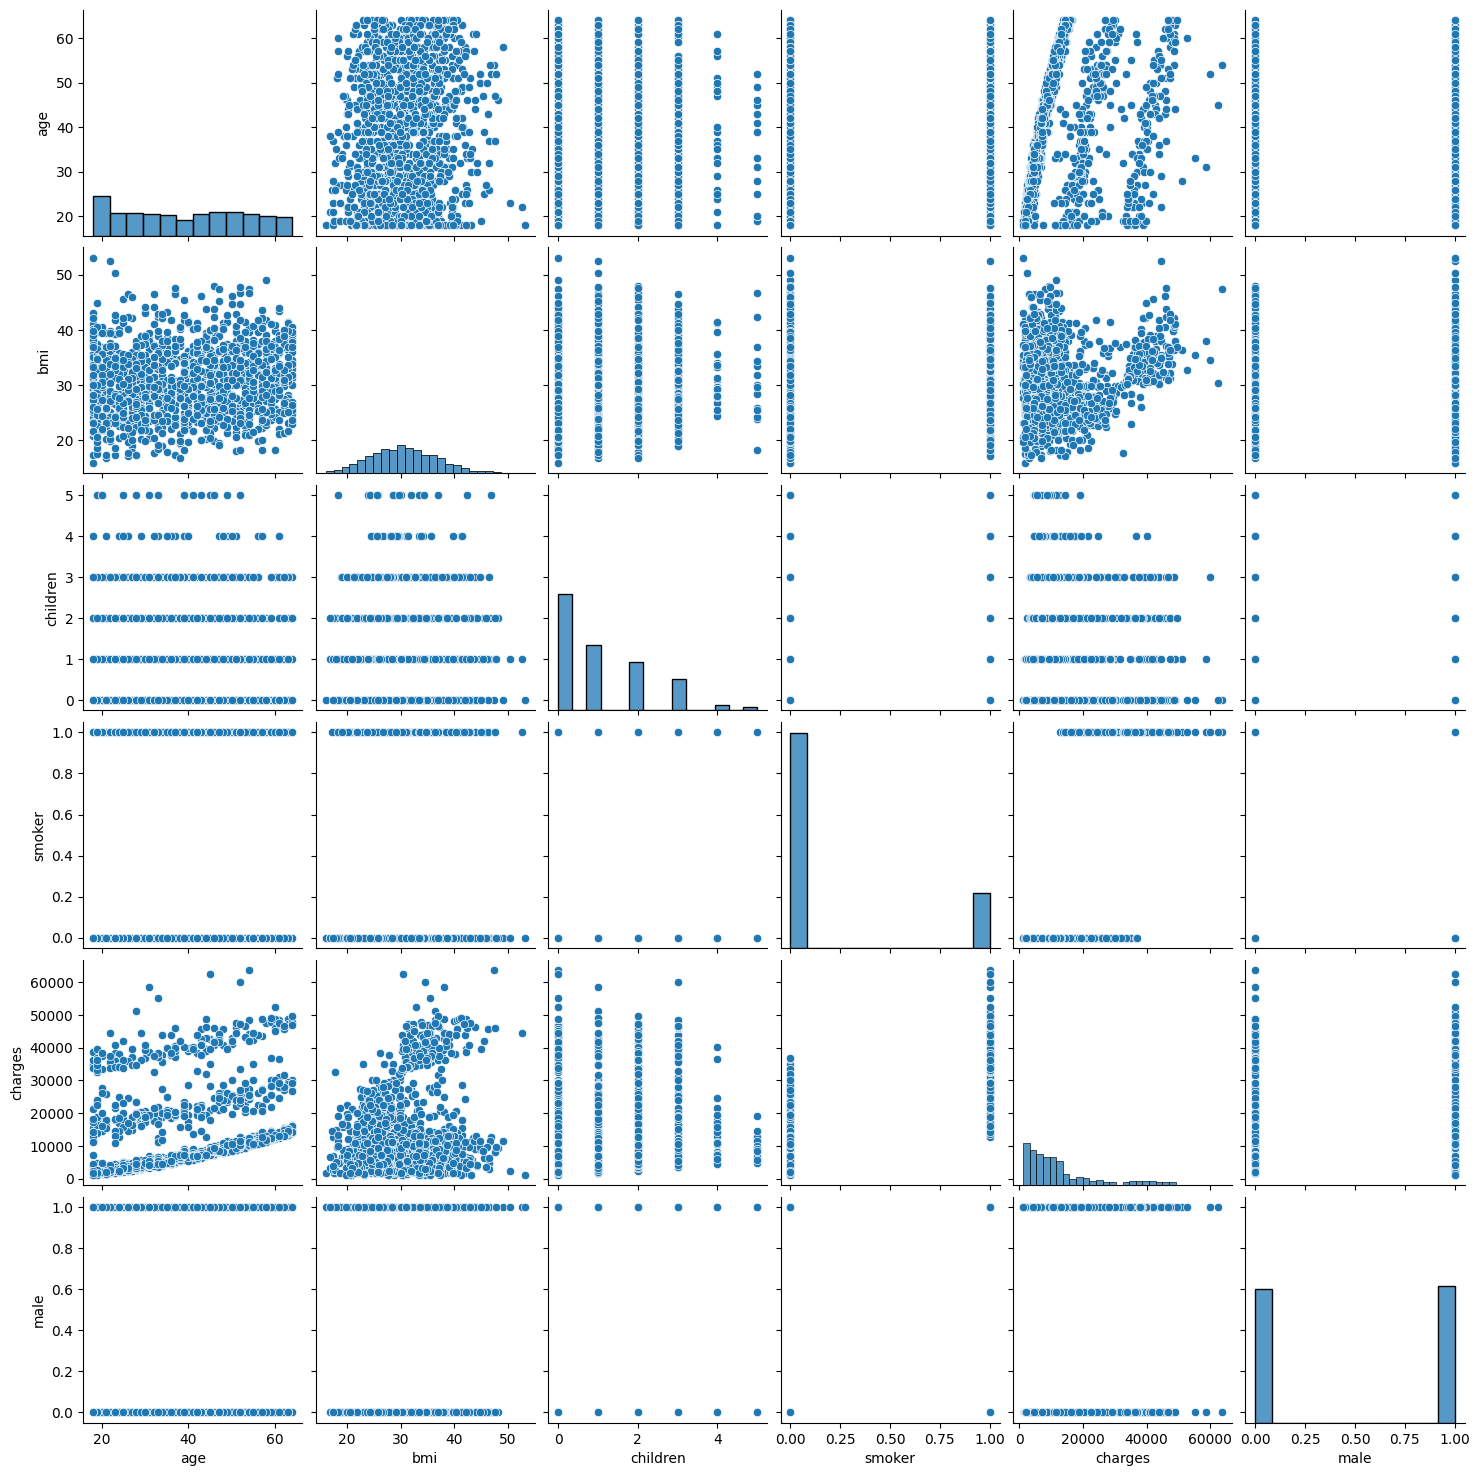

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.pairplot(insurance_data)

# 3. Wykresy rozkładu oraz korelacji zmiennych
## Rozkłady
- Wiek - raczej po równo, lekka przewaga młodzieży
- BMI - więcej ludzi otyłych niż chudziutkich, dane chyba są z USA więc nic dziwnego
- Liczba dzieci - dużo osób bezdzietnych, sporo osób ma 1-3 dzieci, mało kto ma więcej niż 3.
- Opłaty - dużo ludzi płaci raczej niskie stawki, ale jest długi, cienki ogon sięgający aż do 60000
- Palenie - około 20% osób pali, reszta nie
## Korelacje
Nie widzę nic ciekawego, na pierwszy rzut oka widać tylko że im ktoś jest starszy tym więcej będzie płacił, oraz że jak pali to zapłaci więcej.

/tmp/ipykernel_10663/299419401.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insurance_data['charges'])


<Axes: xlabel='charges', ylabel='Density'>

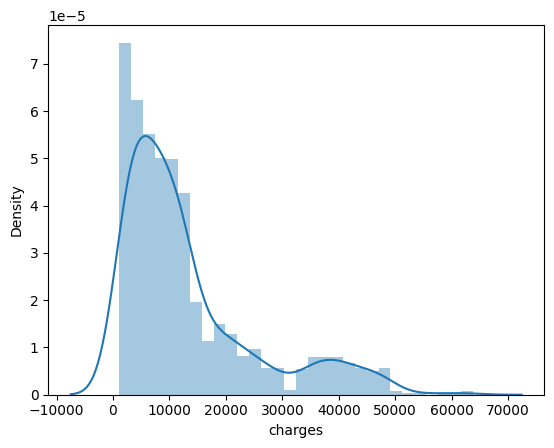

In [24]:
sns.distplot(insurance_data['charges'])

# 4. Wykres rozkładu zmiennej zależnej
Ciekawa górka w przedziale 30-40k, czyżby to byli palacze? Albo otyli palacze? Rozkład leptokurtyczny.

# 5. Modele zbudowane za pomocą statsmodels oraz sklearn
Są poniżej - najpierw model z sklearn, a potem ze statsmodels

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

y = insurance_data.pop('charges')
X = insurance_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm = LinearRegression()
lm.fit(X_train,y_train)


LinearRegression()

In [38]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,234.592830
bmi,364.256063
children,474.555726
smoker,23561.902320
male,41.829409


# Intepretacje wyników modelu
- Po każdych urodzinach opłata wzrośnie średnio o 234.59 ceteris paribus - zgadza sie z tym co myślałem na początku
- Wzrost BMI o 1 pkt prowadzi do wzrostu opłaty średnio o 364.25 ceteris paribus - zgadza się z tym co myślałem na początku
- Zwiększenie liczby potomków o 1 zwiększa opłatę średnio o 474.55 ceteris paribus - odwrotnie niż myślałem na początku
- Fakt palenia papierosów zwiększa opłatę średnio o 23561.90 ceteris paribus - zgadza się z tym co myślałem na początku
- Bycie mężczyzną zwiększa opłatę średnio o 41.82 ceteris paribus - niezbyt istotny wpływ, czyli zgadza się z tym co myślałem na początku

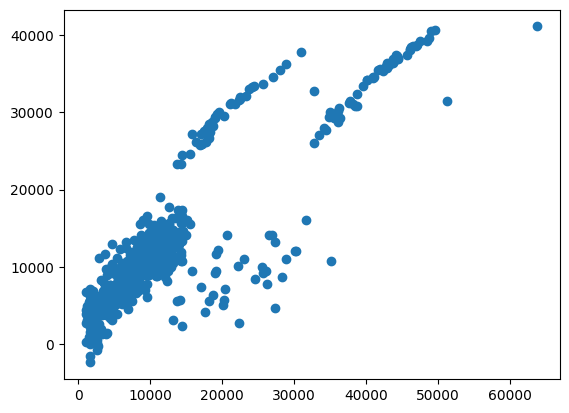

In [36]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [37]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3927.0193905026285
RMSE: 5632.7877300367045


# 6. Predykcje i ocena dopasowania na zbiorze testowym
- Rozrzucone wartości mniej więcej na środku wykresu, w przedziale od 10 do 30k. Tam coś jest nie tak, może dlatego że usunąłem regiony z modelu.
- MAE: 3927 - model średnio myli się o 3927, odchylenie standardowe zmiennej objaśnianej to 12110 - mogło być lepiej, ale wydaje się że nie jest najgorzej.
- RMSE: 5632 - zdarzały się też większe pomyłki modelu, co widać po tym, że RMSE jest znacznie większe od MAE. Niedobrze.

In [39]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              1053.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        18:59:27   Log-Likelihood:                         -8205.2
No. Observations:                 802   AIC:                                  1.642e+04
Df Residuals:                     797   BIC:                                  1.644e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# 7. Intepretacja oszacowań modelu oraz własności statystycznych modelu
- Płeć i posiadanie dzieci nieistotne statystycznie (wysokie p-value, powyżej 0.2)
- Wiek istotny statystycznie - wzrost wieku o 1 powoduje wzrost opłat średnio o 171.42 ceteris paribus
- BMI istotne statystycznie - wzrost wskaźnika BMI o 1 powoduje wzrost opłat średnio o 75.3817 ceteris paribus
- Palenie papierosów istotne statystycznie - jeśli ktoś pali papierosy to będzie płacił średnio 23020 więcej niż gdyby nie palił ceteris paribus

## Jakość modelu
- R kwadrat równe 0.869 świadczy o dobrym dopasowaniu krzywej regresji. Może przy uwzględnieniu regionów byłoby lepiej, a może nie. Model nieidealny, ale też nienajgorszy.
- Współczynnik Durbina-Watsona bliski 2, czyli można powiedzieć, że w modelu jest losowy rozkład reszt, czyli dobrze.